## Example of Ensemble Methods Using Bagging
## In this notebook we use the sk-learn "load_digits" dataset to test our algorithm

## 1) Overview

In this notebook, we will compare two classifiers implemented in `rice_ml` code:
- A single **decision tree** classifier (high-variance model).
- A **bagging** ensemble that trains many trees on bootstrap samples and averages their predictions to reduce variance.

We will use scikit-learn’s `load_digits` dataset (handwritten digits)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns

from rice_ml.supervised_learning.ensemble_methods import bagging_classifier
from rice_ml.supervised_learning.decision_tree import decision_tree
from rice_ml.supervised_learning.preprocess import train_test_split 

print("Loaded classes:", decision_tree, bagging_classifier)


Loaded classes: <class 'rice_ml.supervised_learning.decision_tree.decision_tree'> <class 'rice_ml.supervised_learning.ensemble_methods.bagging_classifier'>


## 2) Load and inspect the dataset

We load the digits dataset and look at basic shapes so we know what the models will see 

The data set is loaded as a numeric feature matrix `X` and label vector `y`

In [2]:

digits = load_digits()
X = digits.data          # shape: (n_samples, 64) -> flattened 8x8 images
y = digits.target.astype(float)  # your tree expects numeric labels; float is fine

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))


X shape: (1797, 64)
y shape: (1797,)
Unique classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Now we can visualize a few examples to connect the feature vectors to the handwritten digits they represent.

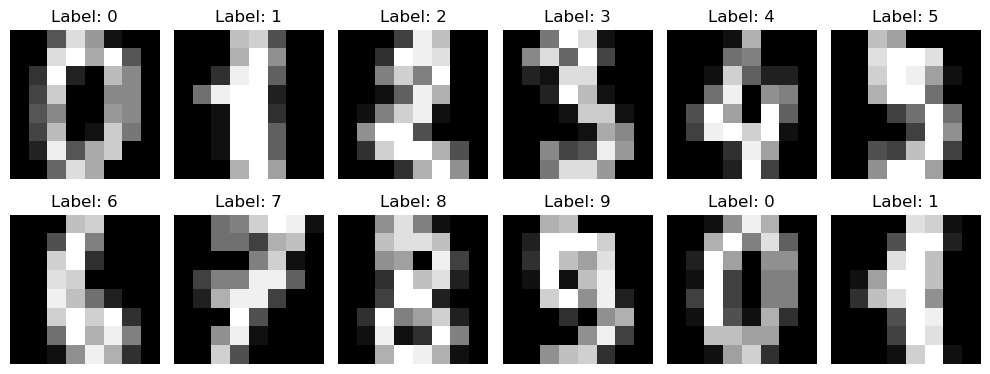

In [3]:

fig, axes = plt.subplots(2, 6, figsize=(10, 4))
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap="gray")
    ax.set_title(f"Label: {int(digits.target[i])}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## 3) Train/test split

Before we can use our models, we need to split the `load_digits` dataset into a testing and training class. We set `shuffle=1` so that the testing and training split is randomized. 

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=1
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (1348, 64) (1348,)
Test : (449, 64) (449,)


## 4) We will use confusion matricies to help observe the accuracy of our models

Here we define a helper function to make plotting nice confusion matricies diagrams easier

In [5]:
def plot_confusion_matrixs(
    cm,
    title="Confusion Matrix"):

    """
    cm : array-like of shape (n_classes, n_classes)
        Confusion matrix
    """

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=True,
        square=True,
        linewidths=0.5,
        linecolor="gray"
    )
    class_names = [str(i) for i in range(10)]
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)

    if class_names is not None:
        plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
        plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)

    plt.tight_layout()
    plt.show()




## 5) Baseline model: a single decision tree from `rice_ml.supervised_learning.decision_tree`

In the next cell, we fit the `decision_tree` class on the training data and evaluate accuracy on the test set. This is our baseline for comparison to the `bagging_classifier`.

For more information on the `decision_tree` model look at **examples/supervised_learning/decision_tree**.

We observer an accuracy for the single `decision_tree` to be about **90.42%**

In [6]:
tree = decision_tree(
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
)

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

acc_tree = accuracy_score(y_test, y_pred_tree)
print("Single decision tree accuracy:", acc_tree)


Single decision tree accuracy: 0.9042316258351893


Now that we have fitted our decision tree, we print a classification report and confusion matrix to see which digits the single tree makes the most errors in classifying.

Classification report (single tree):
              precision    recall  f1-score   support

         0.0     0.9773    0.9348    0.9556        46
         1.0     0.8250    1.0000    0.9041        33
         2.0     0.9375    0.8654    0.9000        52
         3.0     0.7778    0.8537    0.8140        41
         4.0     0.9286    0.8864    0.9070        44
         5.0     0.9535    0.8367    0.8913        49
         6.0     0.9778    0.9778    0.9778        45
         7.0     0.9500    0.9500    0.9500        40
         8.0     0.8462    0.8980    0.8713        49
         9.0     0.8800    0.8800    0.8800        50

    accuracy                         0.9042       449
   macro avg     0.9054    0.9083    0.9051       449
weighted avg     0.9084    0.9042    0.9048       449



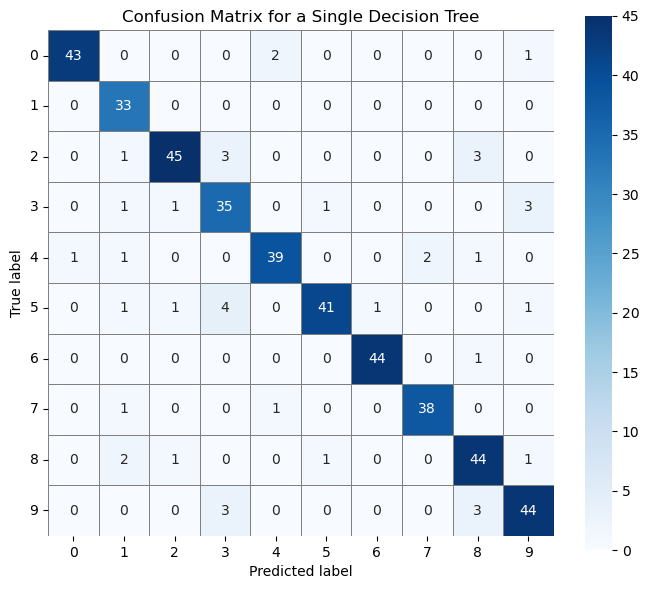

In [7]:

print("Classification report (single tree):")
print(classification_report(y_test, y_pred_tree, digits=4))

cm_tree = confusion_matrix(y_test, y_pred_tree, labels=np.unique(y))
plot_confusion_matrixs(cm_tree, title="Confusion Matrix for a Single Decision Tree")



## 6) Bagging model: many custom trees on bootstrap samples

Now we use the `bagging_classifier` class, which repeatedly samples (with replacement) from the training set, training a new tree each time, and then averages predicted probabilities at inference. This helps minimize variance in the models classifications. 

Here we train a `bagging_classifier` with `n_estimators=50`. This means we are using 50 `decision trees` for out model. 

We then print the confusion matrix and classification report to compare the `bagging_classifier` to the `decision tree`.


Custom bagging accuracy: 0.9710467706013363
Accuracy improvement (bagging - single tree): 0.06681514476614692
Classification report (bagging_classifier):
              precision    recall  f1-score   support

         0.0     1.0000    0.9565    0.9778        46
         1.0     0.9706    1.0000    0.9851        33
         2.0     0.9804    0.9615    0.9709        52
         3.0     0.9318    1.0000    0.9647        41
         4.0     0.9556    0.9773    0.9663        44
         5.0     1.0000    1.0000    1.0000        49
         6.0     1.0000    0.9778    0.9888        45
         7.0     0.9756    1.0000    0.9877        40
         8.0     0.9200    0.9388    0.9293        49
         9.0     0.9787    0.9200    0.9485        50

    accuracy                         0.9710       449
   macro avg     0.9713    0.9732    0.9719       449
weighted avg     0.9717    0.9710    0.9710       449



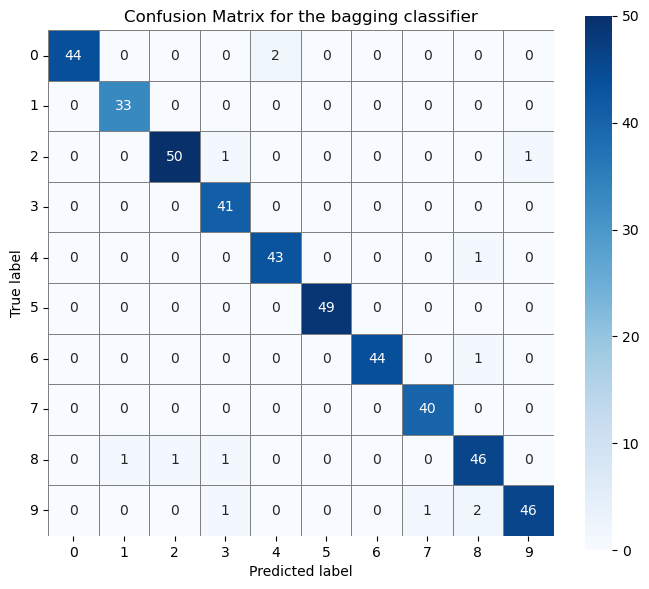

In [8]:

bagger = bagging_classifier(
    n_estimators=50,
    max_samples=1.0,
    random_state=42,
    base_params={
        "max_depth": 15,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42,
    },
)

bagger.fit(X_train, y_train)
y_pred_bag = bagger.predict(X_test)

acc_bag = accuracy_score(y_test, y_pred_bag)
print("Custom bagging accuracy:", acc_bag)
print("Accuracy improvement (bagging - single tree):", acc_bag - acc_tree)

print("Classification report (bagging_classifier):")
print(classification_report(y_test, y_pred_bag, digits=4))

cm_bag = confusion_matrix(y_test, y_pred_bag, labels=np.unique(y))
plot_confusion_matrixs(cm_bag, title="Confusion Matrix for the bagging classifier")


From the plots above, we observe that the `bagging_classifier` is aabout **6.68** percent more accurate than the `decision tree`.
We also see that the `bagging_classifier` has far fewer confused examples in the testing data than the `decision tree`.

## 7) Why Bagging Helps: Variance Reduction

A single decision tree can be very sensitive to the exact training data it sees (high variance).
Bagging reduces variance by averaging many slightly different trees trained on different bootstrapped samples.

In the next cell, we run an experiment by varying `n_estimators` and measuring test accuracy to see how performance changes as we add more trees.

In [9]:

def evaluate_bagging(n_estimators_list, max_samples=1.0, base_params=None, seed=42):
    base_params = base_params or {}
    accs = []
    for n in n_estimators_list:
        model = bagging_classifier(
            n_estimators=n,
            max_samples=max_samples,
            random_state=seed,
            base_params=base_params,
        )
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        accs.append(accuracy_score(y_test, pred))
    return np.array(accs)

n_list = [1, 5, 10, 25, 50, 100]
accs = evaluate_bagging(
    n_list,
    max_samples=1.0,
    base_params={
        "max_depth": 15,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42,
    },
    seed=42,
)

for n, a in zip(n_list, accs):
    print(f"n_estimators={n:>3d} -> accuracy={a:.4f}")


n_estimators=  1 -> accuracy=0.8441
n_estimators=  5 -> accuracy=0.9220
n_estimators= 10 -> accuracy=0.9465
n_estimators= 25 -> accuracy=0.9688
n_estimators= 50 -> accuracy=0.9710
n_estimators=100 -> accuracy=0.9710


In the next cell, we plot accuracy vs. number of estimators. The curve often improves quickly at first and then plateaus as you add more trees. That being said, adding more estimators (especially if you only have a few estimators initially) can greatly improve the model's preformance.

Bagging helps reduce variance by training many copies of a base model, such as a decision tree, on slightly different versions of the training data and then averaging their predictions. High-variance models are sensitive to small changes in the data, meaning that different training samples can produce noticeably different models and predictions. Bagging addresses this by creating multiple bootstrap samples—datasets formed by sampling with replacement from the original data—so that each model sees a slightly different view of the problem. Although each individual model may overfit in a different way, their errors are not perfectly correlated. When their predictions are averaged (or voted on), these random fluctuations tend to cancel out, while consistent patterns in the data are reinforced. As a result, the combined model is more stable and generalizes better than any single model, leading to a reduction in variance without substantially changing the bias.

This is why we see such a sharp increase in the bagging model's accuracy when we change the model from having only a single decision tree to 10 or 25 decision trees.

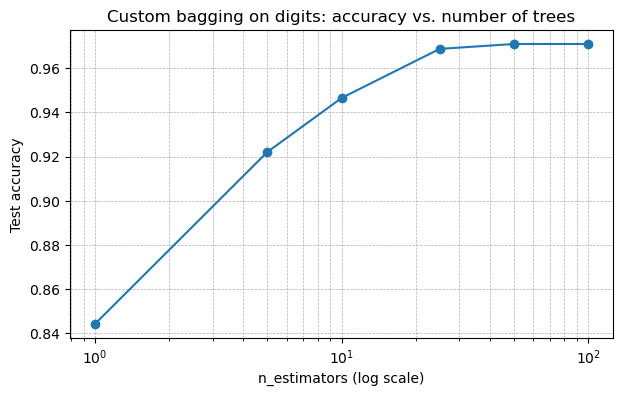

In [10]:

plt.figure(figsize=(7, 4))
plt.plot(n_list, accs, marker="o")
plt.xscale("log")
plt.xlabel("n_estimators (log scale)")
plt.ylabel("Test accuracy")
plt.title("Custom bagging on digits: accuracy vs. number of trees")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## 8) Takeaways

- A **single decision tree** can be **high variance**, meaning its performance can depend heavily on the particular training sample.
- **Bagging** trains many trees on **bootstrap-resampled** versions of the training data and averages their predictions, which typically **reduces variance** and often improves test performance.
- Increasing `n_estimators` usually helps up to a point, after which gains become small.
- `max_samples` trades off individual-tree strength vs. ensemble diversity.


